In [295]:
sum([count_tokens(str(s)) for s in soup.find_all("div", {"class": "slide"})])

240030

In [296]:
token_length = np.array([count_tokens(str(s)) for s in soup.find_all("div", {"class": "slide"})])
gpt_3_mask = token_length < 4096
gpt_4_mask = (token_length > 4096) * (token_length < 8192)
gpt_4_32_mask = (token_length > 8192)

assert token_length[gpt_3_mask].shape[0] + token_length[gpt_4_mask].shape[0] + token_length[gpt_4_32_mask].shape[0] == token_length.shape[0]

((sum(token_length[gpt_3_mask])/1000*0.003) \
+ (sum(token_length[gpt_4_mask])/1000*0.04) \
+ (sum(token_length[gpt_4_32_mask])/1000*0.08))

6.73296

In [290]:
token_length[gpt_4_32_mask]

array([], dtype=int64)

In [212]:
(sum(token_length[gpt_4_32_mask])/1000*0.08)

10.56112

# Slides summary

In [1]:
from pathlib import Path
from typing import Dict
# import fitz
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
from time import sleep
import matplotlib.pyplot as plt
import re


from tqdm import tqdm
import pickle
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances

import warnings
import contextlib
import requests
from urllib3.exceptions import InsecureRequestWarning
import glob
from tqdm import tqdm_notebook, tqdm

old_merge_environment_settings = requests.Session.merge_environment_settings

token = ""

In [2]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(tokenizer.encode(text))

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_FOLDER = "./epam_offerings/"

In [4]:
filenames = glob.glob(f"{DATA_FOLDER}*/*_short.html")
filenames

['./epam_offerings/DASO_Service+Offerings+review+session-20220907_Product+Support_short/Product+Support_short.html',
 './epam_offerings/DASO_Service+Offerings+review+session-20221005_Optimization+Products_short/Optimization+Products_short.html',
 './epam_offerings/DASO_Service+Offerings+review+session-20221012_Operational+Intelligence_short/Operational+Intelligence_short.html',
 './epam_offerings/DASO_Service+Offerings+review+sessions-20220413_Data+Governance_short/Data+Governance_short.html',
 './epam_offerings/DASO_Service+Offerings+review+sessions-20220420_Fast+Data_short/Fast+Data_short.html',
 './epam_offerings/DASO_Service+Offerings+review+sessions-20220427_Data+quality_short/Data+quality_short.html',
 './epam_offerings/DASO_Service+Offerings+review+sessions-20220518_RGM_short/RGM_short.html',
 './epam_offerings/DASO_Service+Offerings+review+sessions-20220608_Computer+vision_short/Computer+vision_short.html']

In [3]:
@contextlib.contextmanager
def no_ssl_verification():
    opened_adapters = set()

    def merge_environment_settings(self, url, proxies, stream, verify, cert):
        # Verification happens only once per connection so we need to close
        # all the opened adapters once we're done. Otherwise, the effects of
        # verify=False persist beyond the end of this context manager.
        opened_adapters.add(self.get_adapter(url))

        settings = old_merge_environment_settings(self, url, proxies, stream, verify, cert)
        settings['verify'] = False

        return settings

    requests.Session.merge_environment_settings = merge_environment_settings

    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', InsecureRequestWarning)
            yield
    finally:
        requests.Session.merge_environment_settings = old_merge_environment_settings

        for adapter in opened_adapters:
            try:
                adapter.close()
            except:
                pass

In [4]:
import os
os.environ["OPENAI_API_BASE"] = "https://openai.lab.epam.com/v1"
import openai

with no_ssl_verification():

    openai.api_key = token
    print(openai.api_key)

    engines = openai.Engine.list()
    print(engines.data[0].id)

fpXwKghwlw4mI8hFn39alhrFUBxbGZRltf4VcpB5dkdt5Gsv3I375ZqGN7AWwF4NPYlXQ4SxGPYMPlkEr7XOlg1sX5
whisper-1


In [15]:
def test_prompt(prompt: str):
    with no_ssl_verification():
        res = openai.Completion.create(prompt=prompt,
                                       temperature=0,
                                       max_tokens=300,
                                       model="text-davinci-003"
                                       )["choices"][0]["text"].strip(" \n")
        return res
def test_prompt_gpt_4(prompt: str):    
    res = openai.ChatCompletion.create(
      model="gpt-4", # "gpt-3.5-turbo" "gpt-4"
      messages=[
            {"role": "user", "content": prompt}
        ]
    )
    res = res["choices"][0]["message"]["content"].strip(" \n")
    return res

In [6]:
filename = "data/INTAKE_copy_cleaned.html"
with open(filename, "r") as f:
    data = f.read()
soup = BeautifulSoup(data, 'lxml')

In [7]:
filename

'data/INTAKE_copy_cleaned.html'

Token indices sequence length is longer than the specified maximum sequence length for this model (4118 > 1024). Running this sequence through the model will result in indexing errors


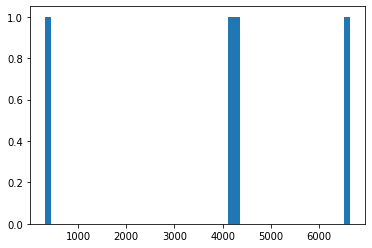

In [8]:
plt.hist([count_tokens(str(s)) for s in soup.find_all("div", {"class": "slide"})], bins=50)
plt.show()

In [16]:

def summarize_slide(slide):

    prompt = f"Q:Give the slide a title and summarize main points of the slide in a detailed way, preserve the structure, include all mentioned approaches and tools\nSlide:\n{str(slide)}\n\nA:"
    
    output = test_prompt_gpt_4(prompt)
    return output



In [21]:
i = 3
slide = str(soup.find_all("div", {"class": "slide"})[i])
out = summarize_slide(slide)

In [22]:
print(out)

Title: Unified Product Governance Planning - Intake (Continued)

Main Points:
1. Initial Requirements Gathering
   - Deep dive functional sessions (Q&A, whiteboarding, etc.)
   - Analyze existing Epic & User Story Backlog
   - Personas & User Journey analysis
   - Platforms issues & non-functional requirements gathering

2. Product Backlog Composition & Clarification
   - Structuring Functional model of the current state to the Product backlog
   - Applying product concept
   - Incorporating new asks from business
   - Processing insights from customer feedbacks
   - Developing recommendations
   - Adding opportunities from competition analysis
   - Mapping functional capabilities to the new User journeys & filling the gaps

3. Backlog Prioritization & Roadmapping
   - Functionality prioritization, based on the business needs & value
   - Definition of the key User journeys to start migration from
   - Functional roadmap definition (as a part of transition plan)
   - UX prototype align

In [195]:
# res = {}
for i, slide in tqdm(enumerate(soup.find_all("div", {"class": "slide"})), leave=True):
    if i+1 not in res:
        try:
            out = summarize_slide(slide)
            res[i+1] = out
        except:
            print(i)
            pass

8it [01:26,  8.94s/it]

7


21it [02:23,  6.84s/it]


In [200]:
i=7
count_tokens(str(soup.find_all("div", {"class": "slide"})[i]))

12364

In [201]:
slide = str(soup.find_all("div", {"class": "slide"})[i])
out_1 = summarize_slide(slide[:int(len(slide)/2)])
out_2 = summarize_slide(slide[int(len(slide)/2):])

In [202]:
print(out_1)
print()
print(out_2)

Title: We Cover the Full Lifecycle of Computer Vision Projects

Summary: 
This slide highlights the full lifecycle of computer vision projects, covering every phase from discovery to evolution or hand-over. The various phases include Discovery (1-2 weeks), POC and/or MVP (2-6 months), Development (3+ months), Testing and Deployment (3+ months), and Evolution or Hand-over. Each phase comes with its specific objectives and deliverables. Key approaches and tools involved in each step are outlined, ensuring a comprehensive understanding of the entire process.

Title: Change Management Framework for Data-Driven Solutions

Main Points:

1. Implement the Data Pipeline
   - Create a reliable data pipeline to collect and process data

2. Refine and Extend the Datasets
   - Continuously improve dataset quality by refining and extending data sources

3. Implement the Model and Run QA Tests
   - Develop the machine learning model and execute quality assurance tests to ensure optimal performance

4

In [203]:
out_1

'Title: We Cover the Full Lifecycle of Computer Vision Projects\n\nSummary: \nThis slide highlights the full lifecycle of computer vision projects, covering every phase from discovery to evolution or hand-over. The various phases include Discovery (1-2 weeks), POC and/or MVP (2-6 months), Development (3+ months), Testing and Deployment (3+ months), and Evolution or Hand-over. Each phase comes with its specific objectives and deliverables. Key approaches and tools involved in each step are outlined, ensuring a comprehensive understanding of the entire process.'

In [204]:
out_2

"Title: Change Management Framework for Data-Driven Solutions\n\nMain Points:\n\n1. Implement the Data Pipeline\n   - Create a reliable data pipeline to collect and process data\n\n2. Refine and Extend the Datasets\n   - Continuously improve dataset quality by refining and extending data sources\n\n3. Implement the Model and Run QA Tests\n   - Develop the machine learning model and execute quality assurance tests to ensure optimal performance\n\n4. Develop CV Workflow Automation\n   - Automate computer vision workflows for seamless integration in data processing pipelines\n\n5. Perform Ongoing AB Testing and Iterative Model Improvement\n   - Conduct continuous AB tests and incrementally refine the model based on performance and feedback\n\n6. Establish QA Process\n   - Implement a rigorous quality assurance process to maintain the model's performance\n\n7. Integrate the Model with Existing Staging and Production Environments\n   - Seamlessly integrate the model with existing infrastruc

In [205]:
out = """Title: We Cover the Full Lifecycle of Computer Vision Projects\n\nSummary: \nThis slide highlights the full lifecycle of computer vision projects, covering every phase from discovery to evolution or hand-over. The various phases include Discovery (1-2 weeks), POC and/or MVP (2-6 months), Development (3+ months), Testing and Deployment (3+ months), and Evolution or Hand-over. Each phase comes with its specific objectives and deliverables. Key approaches and tools involved in each step are outlined, ensuring a comprehensive understanding of the entire process.\n\nMain Points:\n\n1. Implement the Data Pipeline\n   - Create a reliable data pipeline to collect and process data\n\n2. Refine and Extend the Datasets\n   - Continuously improve dataset quality by refining and extending data sources\n\n3. Implement the Model and Run QA Tests\n   - Develop the machine learning model and execute quality assurance tests to ensure optimal performance\n\n4. Develop CV Workflow Automation\n   - Automate computer vision workflows for seamless integration in data processing pipelines\n\n5. Perform Ongoing AB Testing and Iterative Model Improvement\n   - Conduct continuous AB tests and incrementally refine the model based on performance and feedback\n\n6. Establish QA Process\n   - Implement a rigorous quality assurance process to maintain the model's performance\n\n7. Integrate the Model with Existing Staging and Production Environments\n   - Seamlessly integrate the model with existing infrastructure for a smooth transition\n\n8. Perform Ongoing AB Testing and Application Maintenance\n   - Continuously monitor the model's performance and make necessary updates to ensure it remains relevant and useful\n\n9. Maintain Model and Complete Knowledge Transfer\n   - Keep the model up-to-date and ensure all stakeholders understand its functionality and use-cases\n\n10. Improve Quality with Human-In-The-Loop Approach\n    - Leverage human expertise to improve model accuracy, incorporating user feedback into model training and refinement\n\n11. Team Roles\n    - Solution Architect, Senior Data Scientist, Industry SME, Delivery Manager, Content/Labeling Specialist, Developers, DevOps Engineers, Data Engineers, Test Engineers\n\n12. Tools\n    - Utilize a diverse set of tools and technologies to develop and maintain the data-driven solution"""

In [206]:
print(out)

Title: We Cover the Full Lifecycle of Computer Vision Projects

Summary: 
This slide highlights the full lifecycle of computer vision projects, covering every phase from discovery to evolution or hand-over. The various phases include Discovery (1-2 weeks), POC and/or MVP (2-6 months), Development (3+ months), Testing and Deployment (3+ months), and Evolution or Hand-over. Each phase comes with its specific objectives and deliverables. Key approaches and tools involved in each step are outlined, ensuring a comprehensive understanding of the entire process.

Main Points:

1. Implement the Data Pipeline
   - Create a reliable data pipeline to collect and process data

2. Refine and Extend the Datasets
   - Continuously improve dataset quality by refining and extending data sources

3. Implement the Model and Run QA Tests
   - Develop the machine learning model and execute quality assurance tests to ensure optimal performance

4. Develop CV Workflow Automation
   - Automate computer vision

In [207]:
i+1

8

In [208]:
res[i+1] = out

In [209]:
import pickle
with open(filename.replace("_short.html", "_summary.pkl"), "wb") as f:
    pickle.dump(res, f)

In [186]:
with open(filename.replace("_short.html", "_summary.pkl"), "rb") as f:
    check = pickle.load(f)
check == res

True

In [199]:
res.keys()

dict_keys([2, 3, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 1, 4, 5, 11, 16])

In [310]:
filename

'./epam_offerings/DASO_Service+Offerings+review+sessions-20220608_Computer+vision_short/Computer+vision_short.html'

In [311]:
filename = filenames[7]
with open(filename, "r") as f:
    data = f.read()
    soup = BeautifulSoup(data, 'lxml')
    
with open(filename.replace("_short.html", "_summary.pkl"), "rb") as f:
    check = pickle.load(f)

In [312]:
check = dict(sorted(check.items(), key=lambda x: x[0]))

In [313]:
real_slide_nums = [int(re.findall("\d{1,2}$", el["id"])[0]) for el in soup.find_all("div", {"class": "slide"})]
real_slide_nums = np.array(real_slide_nums)[np.array(list(check.keys())) - 1].tolist()
if not (real_slide_nums == list(check.keys())):
    print(list(zip(real_slide_nums, list(check.keys()))))


[(1, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (10, 8), (11, 9), (12, 10), (13, 11), (14, 12), (15, 13), (16, 14), (18, 15), (19, 16), (20, 17), (21, 18), (22, 19), (23, 20), (24, 21)]


In [314]:
assert len(check) == len(real_slide_nums)

In [315]:
corrected = {true_n: v for (k, v), true_n in zip(check.items(), real_slide_nums)}

In [316]:
(real_slide_nums == list(corrected.keys()))

True

In [317]:
with open(filename.replace("_short.html", "_summary_corrected.pkl"), "wb") as f:
     pickle.dump(corrected, f)

In [ ]:
Full Lifecycle of Computer Vision Projects